# Libraries

In [137]:
import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt
from pathlib import Path
import sys

root = str(Path().resolve().parent)
if root not in sys.path:
    sys.path.append(root)
print(*sys.path, sep="\n")

# %matplotlib ipympl
%matplotlib inline

/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/ryanwtsai/repos/rfdsp_sim/python/venv/lib/python3.12/site-packages
/home/ryanwtsai/repos/rfdsp_sim/python


In [138]:
from importlib import reload
from rfdsppy import calc, ofdm, rf_analog as rfa, rf_tx_fw, tonegen, digital_filter_design, rx_dfe_impcomp as rx_impcomp, digital_hw_algo as dighw

reload(calc)
reload(ofdm)
reload(rfa)
reload(rf_tx_fw)
reload(tonegen)
reload(digital_filter_design)
reload(rx_impcomp)
reload(dighw)

<module 'rfdsppy.digital_hw_algo' from '/home/ryanwtsai/repos/rfdsp_sim/python/rfdsppy/digital_hw_algo.py'>

# Rect-to-polar and polar-to-rect conversions

In [280]:
# Generate sample waveform

nsym = 14
modorder = 256
bw = 20
scs = 15
num_sc = 1200
num_sc = 36
start_sc = 600-round(num_sc/2)
en_tprecode = False
osr = 1
wola = 1
# sig_frac_bits = 15
# sig_power = -19
wg = ofdm.OFDMWavGen(bw, scs, modorder, start_sc, num_sc=num_sc, en_tprecode=en_tprecode, osr=osr, wola=wola)

x, x_standard = wg.generate(nsym)
cfg = wg.get_demod_params()
fs = cfg.get("fs")
wola_len = cfg.get("wola_len")

In [281]:
# Initialize CORDIC in vectoring mode

N = 5
cordic = dighw.CORDIC(N, "vectoring")
print(cordic.N)
print(cordic.mode)
print(cordic.sim_type)
print(cordic.theta)
print(cordic.K_)
# print(cordic.theta_i_)
# print(cordic.rot_mat_m_[-1])
# print(cordic.rot_mat_p_[-1])

5
vectoring
vectorized
None
0.6076482562561683


EVM: 0.6401%


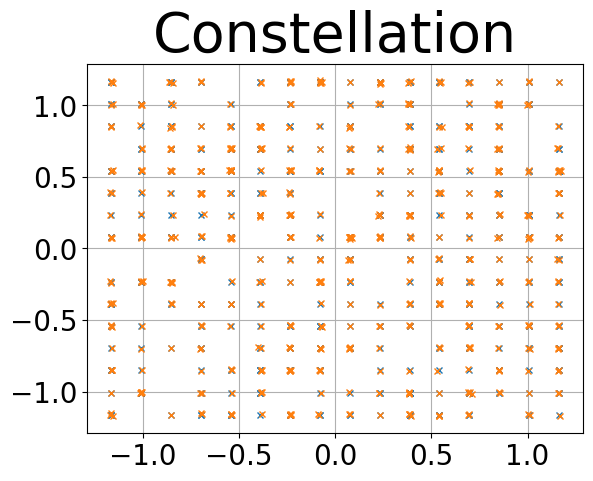

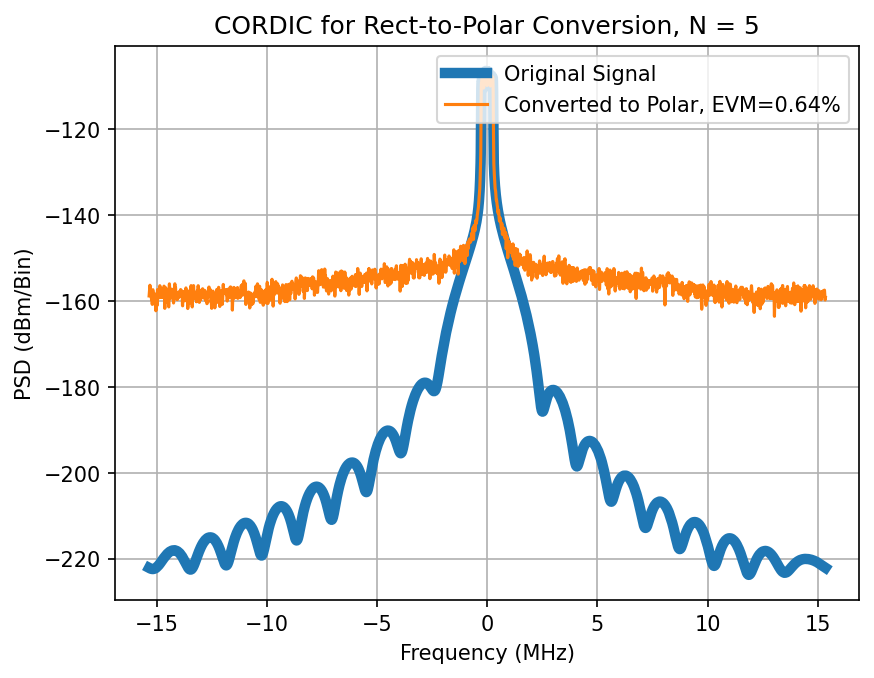

In [282]:
# Rectangular-to-polar conversion

env, ph = cordic.transform(x.real, x.imag)
x_polar = env*np.exp(1j*ph)

evm = wg.calculate_evm(x[round(wola_len/2):], x_polar[round(wola_len/2):], en_plot=True)
print(f"EVM: {round(evm,4)}%")

py, f = calc.psd(x_polar, fs, fs/2**12)
px, _ = calc.psd(x, fs, fs/2**12)

fig, axs = plt.subplots(dpi=150)
axs.plot(f, 10*np.log10(px), label="Original Signal", linewidth=5)
axs.plot(f, 10*np.log10(py), label=f"Converted to Polar, EVM={round(evm,2)}%")
axs.set_title(f"CORDIC for Rect-to-Polar Conversion, N = {N}")
axs.set_xlabel("Frequency (MHz)")
axs.set_ylabel("PSD (dBm/Bin)")
axs.grid()
axs.legend(loc="best")

In [255]:
# Initialize CORDIC in rotation mode

cordic1 = dighw.CORDIC(N, "rotation")
print(cordic1.N)
print(cordic1.mode)
print(cordic1.sim_type)
print(cordic1.theta)
print(cordic1.K_)
# print(cordic1.theta_i_)
# print(cordic1.rot_mat_m_[-1])
# print(cordic1.rot_mat_p_[-1])

5
rotation
vectorized
None
0.6076482562561683


EVM: 1.8876%


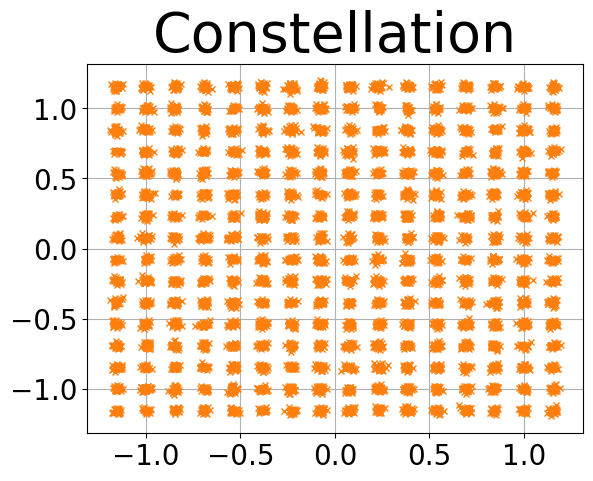

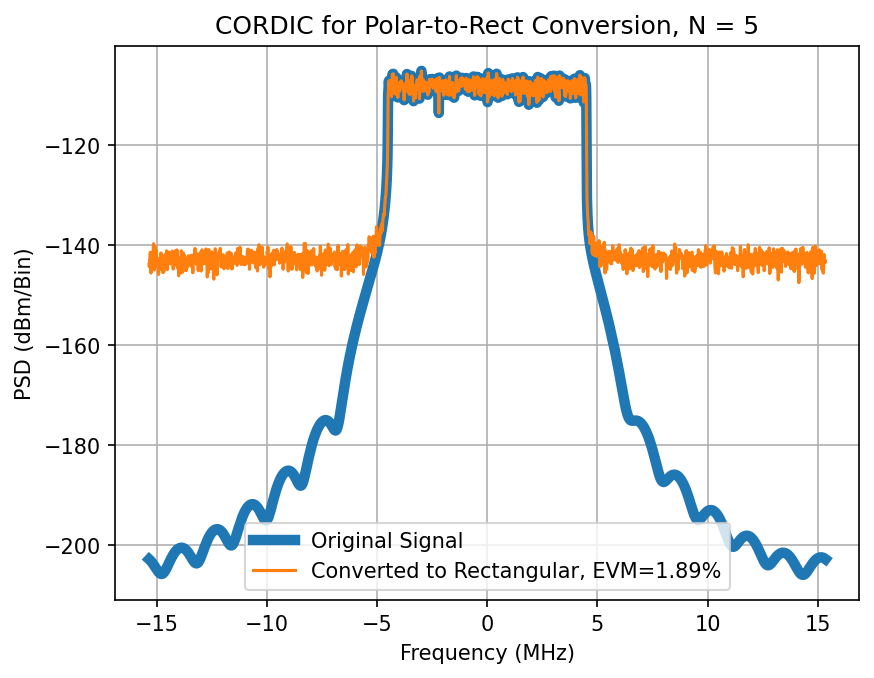

In [257]:
# Polar-to-rectangular conversion

env = np.abs(x)
ph = np.angle(x)
x_polar = env*np.exp(1j*ph)
I, Q = cordic1.transform(env, ph)
x_rect = I + 1j*Q

evm = wg.calculate_evm(x_polar[round(wola_len/2):], x_rect[round(wola_len/2):], en_plot=True)
print(f"EVM: {round(evm,4)}%")

py, f = calc.psd(x_rect, fs, fs/2**12)
px, _ = calc.psd(x_polar, fs, fs/2**12)

fig, axs = plt.subplots(dpi=150)
axs.plot(f, 10*np.log10(px), label="Original Signal", linewidth=5)
axs.plot(f, 10*np.log10(py), label=f"Converted to Rectangular, EVM={round(evm,2)}%")
axs.set_title(f"CORDIC for Polar-to-Rect Conversion, N = {N}")
axs.set_xlabel("Frequency (MHz)")
axs.set_ylabel("PSD (dBm/Bin)")
axs.grid()
axs.legend(loc="best")

# Phase shift

# Frequency shift

In [276]:
# Generate sample waveform

nsym = 14*10
modorder = 256
bw = 20
scs = 15
num_sc = 36
start_sc = 600-round(num_sc/2)
en_tprecode = False
osr = 1
wola = 1
# sig_frac_bits = 15
# sig_power = -19
wg = ofdm.OFDMWavGen(bw, scs, modorder, start_sc, num_sc=num_sc, en_tprecode=en_tprecode, osr=osr, wola=wola)

x, x_standard = wg.generate(nsym)
cfg = wg.get_demod_params()
fs = cfg.get("fs")
wola_len = cfg.get("wola_len")

In [277]:
# Initialize CORDIC in rotation mode

N = 5

rng = np.random.default_rng()
f0 = rng.uniform(low=0.5, high=13) # rotation frequency (MHz)
w0 = f0*2*np.pi/fs # rotation frequency (radians/sample)

theta = w0*np.arange(x.size, dtype="float")

cordic1 = dighw.CORDIC(N, "rotation", theta=theta)
# cordic2 = dighw.CORDIC(N, "rotation", theta=-theta)
print(cordic1.N)
print(cordic1.mode)
print(cordic1.sim_type)
print(cordic1.theta.shape)
print(f0)

5
rotation
vectorized
(306760,)
1.3813019331969776


EVM: 0.3839130702987471%


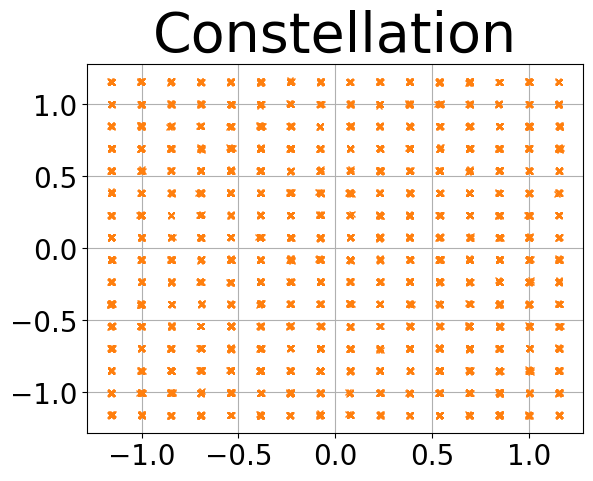

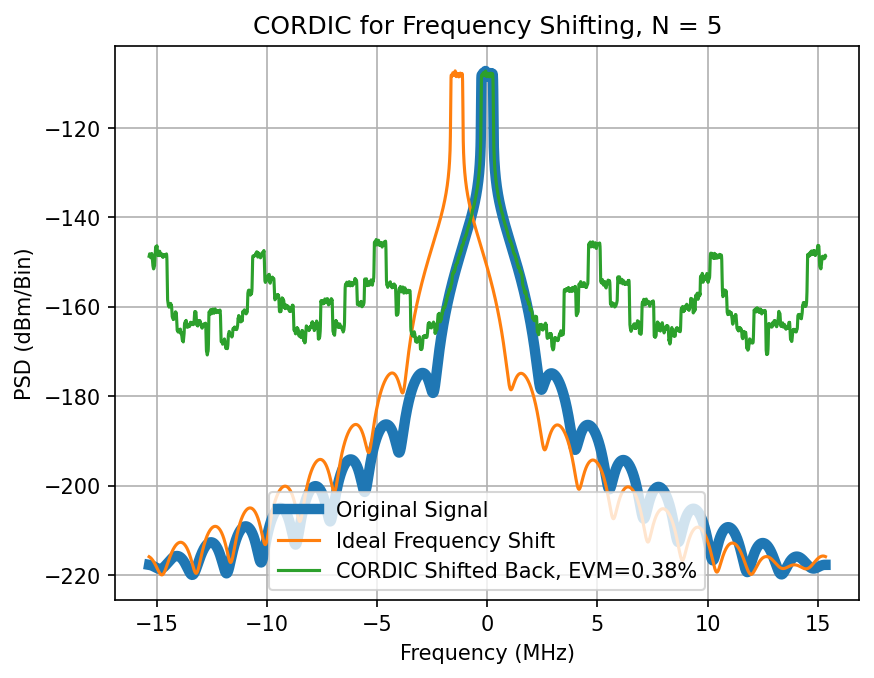

In [278]:
x_fshift = x*np.exp(-1j*w0*np.arange(x.size, dtype="float"))
I, Q = cordic1.transform(x_fshift.real, x_fshift.imag)
x_rec = I + 1j*Q

# I2, Q2 = cordic2.transform(x_fshift.real, x_fshift.imag)
# x_rec = I2 + 1j*Q2

evm = wg.calculate_evm(x[round(wola_len/2):], \
                       x_rec[round(wola_len/2):], en_plot=True)
print(f"EVM: {evm}%")

py, f = calc.psd(x_fshift, fs, fs/2**12)
px, _ = calc.psd(x, fs, fs/2**12)
py2, _ = calc.psd(x_rec, fs, fs/2**12)

fig, axs = plt.subplots(dpi=150)
py_dbm = 10*np.log10(py)
axs.plot(f, 10*np.log10(px), label="Original Signal", linewidth=5)
axs.plot(f, py_dbm, label="Ideal Frequency Shift")
axs.plot(f, 10*np.log10(py2), label=f"CORDIC Shifted Back, EVM={round(evm,2)}%")
axs.set_title(f"CORDIC for Frequency Shifting, N = {N}")
axs.set_xlabel("Frequency (MHz)")
axs.set_ylabel("PSD (dBm/Bin)")
axs.grid()
axs.legend(loc="lower center")
# axs.set_xlim(left=-5, right=5)
# axs.vlines([f0], ymin=py_dbm.min(), ymax=py_dbm.max(), colors='r')